In [82]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [83]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [84]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [85]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [86]:
tf.keras.backend.clear_session()

In [87]:
subject = 'Rio Grande Do Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [88]:
data = pd.read_csv('2003_mo_model_input_RS.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH
0,2003-1,8.192273,2.046281e+07,0.813273,2.335964,1008.041778,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,0.701216,135.543840,188.093,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.834825,0.399576,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.775641
1,2003-2,8.186359,2.051916e+07,0.812953,2.025977,1008.772431,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,0.701343,134.468148,170.973,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.835136,0.398811,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.775686
2,2003-3,8.180446,2.057551e+07,0.812634,1.829198,1009.718901,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,0.701470,134.242963,174.880,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.835447,0.397898,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.775731
3,2003-4,8.174533,2.063185e+07,0.812315,1.686795,1010.889835,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,0.701596,133.169391,178.111,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.835759,0.397042,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.775775
4,2003-5,8.168619,2.068820e+07,0.811996,1.685569,1012.010849,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,0.701723,132.046874,184.331,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.836070,0.396050,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.775820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37348.455735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37320.998188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37269.070370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37194.272320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


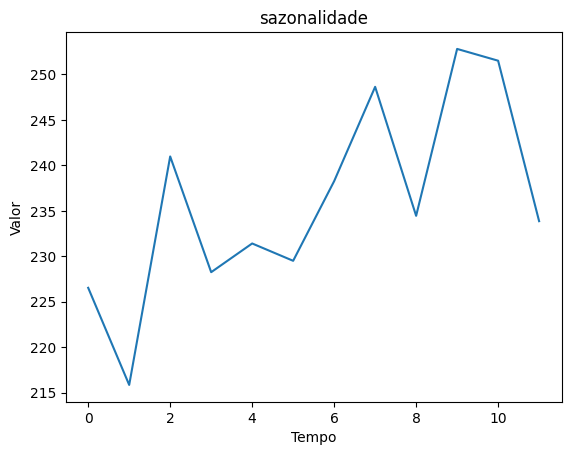

,sazonalidade
sazonalidade,
0,226.535776
1,215.861829
2,240.974809
3,228.253307
4,231.409887
5,229.504290
6,238.259767
7,248.628280
8,234.449571


In [89]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [90]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH,sazonalidade,Rio Grande Do Sul - Consumo de Cimento (t)
0,2003-1,8.192273,2.046281e+07,0.813273,2.335964,1008.041778,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,0.701216,135.543840,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.834825,0.399576,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.775641,226.535776,188.093
1,2003-2,8.186359,2.051916e+07,0.812953,2.025977,1008.772431,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,0.701343,134.468148,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.835136,0.398811,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.775686,215.861829,170.973
2,2003-3,8.180446,2.057551e+07,0.812634,1.829198,1009.718901,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,0.701470,134.242963,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.835447,0.397898,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.775731,240.974809,174.880
3,2003-4,8.174533,2.063185e+07,0.812315,1.686795,1010.889835,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,0.701596,133.169391,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.835759,0.397042,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.775775,228.253307,178.111
4,2003-5,8.168619,2.068820e+07,0.811996,1.685569,1012.010849,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,0.701723,132.046874,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.836070,0.396050,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.775820,231.409887,184.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37348.455735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.409887,NaN
269,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37320.998188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.504290,NaN
270,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37269.070370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.259767,NaN
271,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37194.272320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.628280,NaN


In [91]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      168.412
1      153.593
2      166.196
3      150.226
4      154.220
        ...   
268        NaN
269        NaN
270        NaN
271        NaN
272        NaN
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 273, dtype: float64

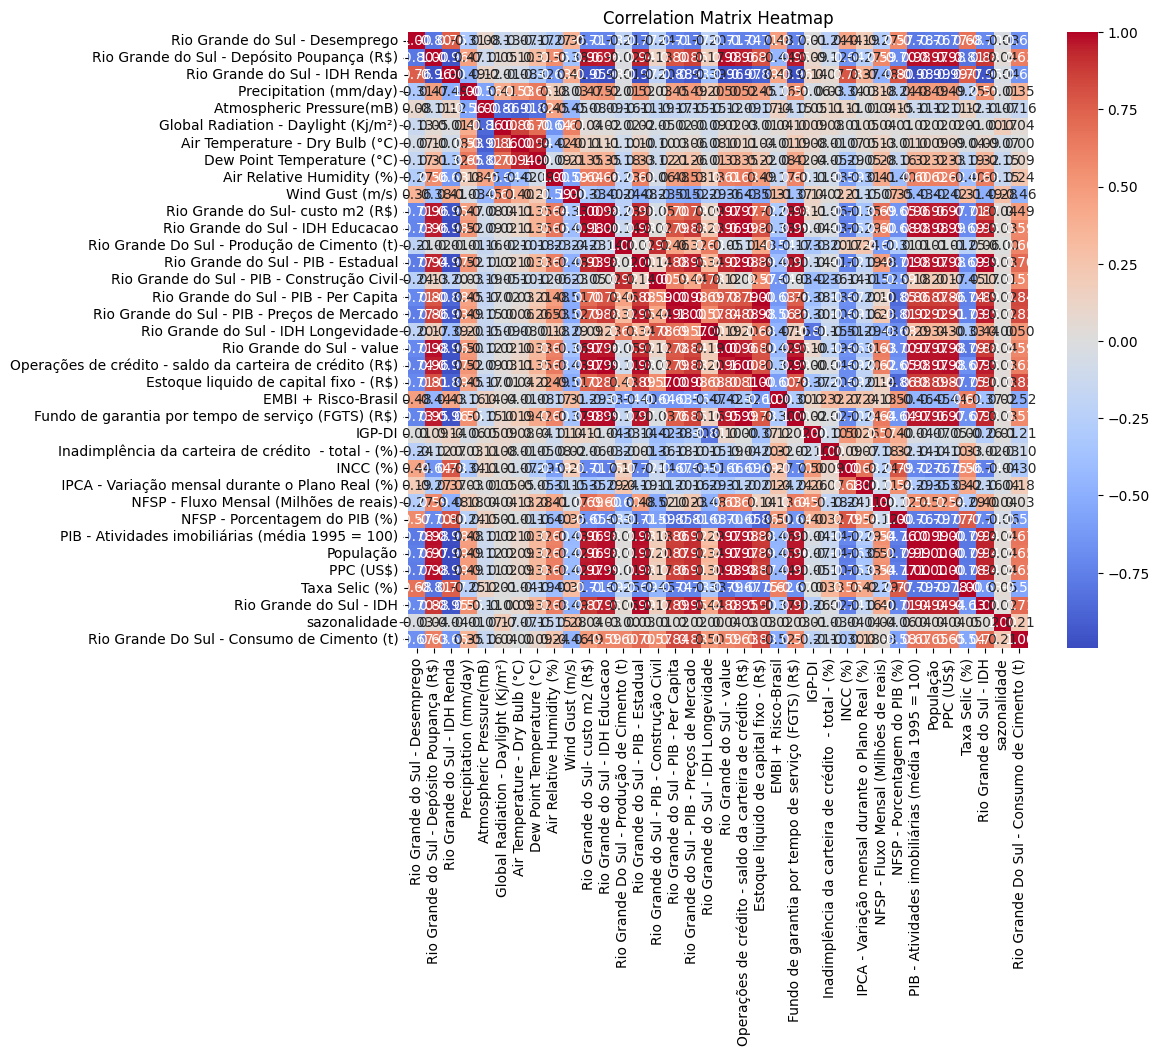

In [92]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [94]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio Grande do Sul - Desemprego,1.642564e+02
1,Rio Grande do Sul - Depósito Poupança (R$),1.797986e+03
2,Rio Grande do Sul - IDH Renda,2.801502e+08
3,Precipitation (mm/day),6.286147e+00
4,Atmospheric Pressure(mB),3.529598e+01
5,Global Radiation - Daylight (Kj/m²),5.730094e+01
6,Air Temperature - Dry Bulb (°C),6.062548e+03
7,Dew Point Temperature (°C),4.976539e+03
8,Air Relative Humidity (%),9.290039e+02
9,Wind Gust (m/s),1.286146e+01


In [95]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 ' NFSP - Fluxo Mensal (Milhões de reais)',
                 'Air Temperature - Dry Bulb (°C)', 
                 'Dew Point Temperature (°C)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,8.192273,2.046281e+07,0.813273,2.335964,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,135.543840,2.066295e+08,0.399576,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,226.535776
1,8.186359,2.051916e+07,0.812953,2.025977,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,134.468148,2.068579e+08,0.398811,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,215.861829
2,8.180446,2.057551e+07,0.812634,1.829198,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,134.242963,2.070864e+08,0.397898,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,240.974809
3,8.174533,2.063185e+07,0.812315,1.686795,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,133.169391,2.073148e+08,0.397042,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,228.253307
4,8.168619,2.068820e+07,0.811996,1.685569,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,132.046874,2.075433e+08,0.396050,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,231.409887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,7.223439,4.455354e+07,0.777122,1.701952,1146.534400,18.497902,14.047423,77.501466,1.459143,28663.085765,122.957924,2.410289e+08,0.697817,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,248.628280
200,7.213648,4.498146e+07,0.777138,1.664668,1274.378444,19.805929,14.689855,75.074775,1.518021,28884.510067,123.216090,2.407310e+08,0.702859,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,234.449571
201,7.203857,4.540937e+07,0.777153,1.639659,1366.401179,21.286197,15.786219,73.658952,1.583319,29107.467408,123.975734,2.404330e+08,0.707138,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,252.795021
202,7.194065,4.583728e+07,0.777168,1.850330,1501.128113,22.411899,16.374222,71.376039,1.606260,29338.587381,124.689287,2.401351e+08,0.711250,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,251.499741


In [96]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.537080,2.088638,1.600998,1.004400,1.428829,1.152467,-1.141291,0.781224,-1.497932,-0.498701,-1.742039,-1.362045,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.529148,2.059993,0.542988,0.521539,1.064699,0.841943,-0.947998,0.596591,-1.477902,-0.549826,-1.725035,-1.370418,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.521217,2.031348,-0.128633,-0.218617,0.481551,0.399191,-0.449659,0.492221,-1.459069,-0.560528,-1.708030,-1.380425,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.513286,2.002704,-0.614665,-0.996230,-0.249353,-0.309533,-0.184140,0.250950,-1.440505,-0.611552,-1.691025,-1.389791,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.505355,1.974059,-0.618849,-1.291265,-0.917109,-0.996261,-0.066065,0.140002,-1.423030,-0.664902,-1.674021,-1.400661,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.853962,-1.154921,-0.562934,-0.255528,-0.663551,-0.566277,0.503353,-0.471135,1.940638,-1.096873,0.818416,1.903729,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,1.914196,-1.153551,-0.690189,0.491702,-0.042575,-0.219899,-0.277618,-0.108468,1.984525,-1.084603,0.796241,1.958942,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,1.974429,-1.152181,-0.775547,1.029563,0.660172,0.371222,-0.733266,0.293748,2.028716,-1.048499,0.774065,2.005801,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,2.034663,-1.150812,-0.056508,1.817023,1.194591,0.688253,-1.467966,0.435055,2.074524,-1.014586,0.751890,2.050829,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [97]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.537080,2.088638,1.600998,1.004400,1.428829,1.152467,-1.141291,0.781224,-1.497932,-0.498701,-1.742039,-1.362045,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.529148,2.059993,0.542988,0.521539,1.064699,0.841943,-0.947998,0.596591,-1.477902,-0.549826,-1.725035,-1.370418,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.521217,2.031348,-0.128633,-0.218617,0.481551,0.399191,-0.449659,0.492221,-1.459069,-0.560528,-1.708030,-1.380425,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.513286,2.002704,-0.614665,-0.996230,-0.249353,-0.309533,-0.184140,0.250950,-1.440505,-0.611552,-1.691025,-1.389791,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.505355,1.974059,-0.618849,-1.291265,-0.917109,-0.996261,-0.066065,0.140002,-1.423030,-0.664902,-1.674021,-1.400661,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.367413,-1.167675,-0.597102,-0.262576,-0.798613,-0.288320,1.675227,1.117414,1.553281,-1.330258,1.037527,1.343916,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,1.380396,-1.167042,-0.412228,0.413237,-0.067895,0.336076,1.177442,1.410898,1.574356,-1.327980,1.024750,1.384534,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,1.393379,-1.166409,-0.100386,0.922837,0.636759,0.951100,0.715580,1.522053,1.596820,-1.292345,1.011973,1.434562,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,1.406362,-1.165777,0.179578,1.288665,1.209686,1.476518,0.440029,1.437965,1.622145,-1.270702,0.999196,1.478361,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [98]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      168.412
1      153.593
2      166.196
3      150.226
4      154.220
        ...   
187    274.061
188    268.268
189    296.991
190    290.683
191    251.597
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 192, dtype: float64

In [99]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [100]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 24)

In [101]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,0.425108,-1.212860,2.624136,0.703002,1.583031,1.975252,0.626331,0.176097,0.910652,-0.518202,1.151400,0.745708,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,0.458092,-1.212536,2.102802,0.189028,1.033794,1.585698,1.183058,-0.237446,0.932577,-0.567144,1.152690,0.744476,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,0.491077,-1.212212,1.099666,-0.638330,0.037214,0.660996,1.671876,-0.545120,0.952273,-0.608848,1.153979,0.742809,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,0.524061,-1.211888,0.844554,-1.194371,-0.733537,-0.108102,1.904850,-0.922470,0.972129,-0.665096,1.155268,0.743024,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,0.557046,-1.211564,-0.123050,-1.436221,-1.473836,-0.908017,1.964780,-1.373846,0.991896,-0.729131,1.156558,0.745159,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,0.590030,-1.211240,-0.554549,-1.282905,-1.751649,-1.300840,1.724109,-1.103229,1.012843,-0.755693,1.157847,0.751442,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,0.623015,-1.210916,0.032291,-0.953610,-1.485663,-1.084966,1.513348,-0.519084,1.033404,-0.825990,1.159137,0.759768,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,0.656000,-1.210592,-0.334673,-0.273338,-1.142254,-0.887057,1.036233,-0.349417,1.053586,-0.857870,1.160426,0.777115,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,0.688984,-1.210268,0.195270,0.430542,-0.540727,-0.399517,0.564424,0.145837,1.073807,-0.903618,1.161716,0.794691,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,0.721969,-1.209944,1.445017,0.950063,0.249148,0.403067,0.366091,0.228572,1.094483,-0.932790,1.163005,0.821447,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [102]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [103]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [104]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(108, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [105]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [106]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1873659248, 1022574420, 744322322, 2861345039, 1304692307, 3081098513, 819444280, 2637143414, 3605866301, 3161706587]


Step: 0 ___________________________________________
val_loss: 438.93829345703125
winner_seed: 1873659248


Step: 1 ___________________________________________
val_loss: 421.88037109375
winner_seed: 1022574420


Step: 2 ___________________________________________
val_loss: 337.04156494140625
winner_seed: 744322322


Step: 3 ___________________________________________
val_loss: 962.2005615234375


Step: 4 ___________________________________________
val_loss: 458.0513610839844


Step: 5 ___________________________________________
val_loss: 372.48712158203125


Step: 6 ___________________________________________
val_loss: 385.3489074707031


Step: 7 ___________________________________________
val_loss: 405.9670715332031


Step: 8 ___________________________________________
val_loss: 561.975830078125


Step: 9 ___________________________________________
val_loss: 476.4539

In [107]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 1668180562

Epoch 1/10000
5/5 [==============================] - 2s 102ms/step - loss: 42266.8789 - val_loss: 2478.9341
Epoch 2/10000
5/5 [==============================] - 0s 10ms/step - loss: 1347.9994 - val_loss: 551.4601
Epoch 3/10000
5/5 [==============================] - 0s 9ms/step - loss: 1276.6627 - val_loss: 926.6240
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 1204.5188 - val_loss: 1186.2124
Epoch 5/10000
5/5 [==============================] - 0s 9ms/step - loss: 1233.8218 - val_loss: 2747.7603
Epoch 6/10000
5/5 [==============================] - 0s 10ms/step - loss: 1494.8875 - val_loss: 546.8056
Epoch 7/10000
5/5 [==============================] - 0s 9ms/step - loss: 1285.4441 - val_loss: 730.5914
Epoch 8/10000
5/5 [==============================] - 0s 10ms/step - loss: 1128.8691 - val_loss: 627.2527
Epoch 9/10000
5/5 [==============================] - 0s 10ms/step - loss: 1335.0166 - val_loss: 547.1900
Epoch 10/10000
5/5 [==============================] -

5/5 [==============================] - 0s 11ms/step - loss: 348.4475 - val_loss: 542.1765
Epoch 80/10000
5/5 [==============================] - 0s 9ms/step - loss: 374.0692 - val_loss: 541.2133
Epoch 81/10000
5/5 [==============================] - 0s 10ms/step - loss: 352.1076 - val_loss: 822.9962
Epoch 82/10000
5/5 [==============================] - 0s 10ms/step - loss: 317.4441 - val_loss: 623.2307
Epoch 83/10000
5/5 [==============================] - 0s 9ms/step - loss: 373.4755 - val_loss: 703.4735
Epoch 84/10000
5/5 [==============================] - 0s 10ms/step - loss: 307.8720 - val_loss: 900.0552
Epoch 85/10000
5/5 [==============================] - 0s 9ms/step - loss: 321.3651 - val_loss: 1093.0133
Epoch 86/10000
5/5 [==============================] - 0s 10ms/step - loss: 344.9357 - val_loss: 1674.4745
Epoch 87/10000
5/5 [==============================] - 0s 9ms/step - loss: 411.5467 - val_loss: 1251.7778
Epoch 88/10000
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 9ms/step - loss: 344.8852 - val_loss: 814.0253
Epoch 157/10000
5/5 [==============================] - 0s 10ms/step - loss: 295.1188 - val_loss: 917.4795
Epoch 158/10000
5/5 [==============================] - 0s 9ms/step - loss: 295.9565 - val_loss: 1051.5519
Epoch 159/10000
5/5 [==============================] - 0s 9ms/step - loss: 300.6703 - val_loss: 564.9175
Epoch 160/10000
5/5 [==============================] - 0s 9ms/step - loss: 360.9843 - val_loss: 745.4055
Epoch 161/10000
5/5 [==============================] - 0s 10ms/step - loss: 319.7183 - val_loss: 1167.1644
Epoch 162/10000
5/5 [==============================] - 0s 9ms/step - loss: 349.2844 - val_loss: 1261.0522
Epoch 163/10000
5/5 [==============================] - 0s 9ms/step - loss: 392.8024 - val_loss: 702.5607
Epoch 164/10000
5/5 [==============================] - 0s 9ms/step - loss: 286.6942 - val_loss: 807.2245
Epoch 165/10000
5/5 [==============================] - 0s 9ms/step

5/5 [==============================] - 0s 9ms/step - loss: 251.5206 - val_loss: 602.2492
Epoch 234/10000
5/5 [==============================] - 0s 9ms/step - loss: 278.3140 - val_loss: 968.1417
Epoch 235/10000
5/5 [==============================] - 0s 10ms/step - loss: 254.3026 - val_loss: 673.2844
Epoch 236/10000
5/5 [==============================] - 0s 9ms/step - loss: 303.4102 - val_loss: 1172.4459
Epoch 237/10000
5/5 [==============================] - 0s 10ms/step - loss: 282.2899 - val_loss: 1032.6661
Epoch 238/10000
5/5 [==============================] - 0s 10ms/step - loss: 263.4330 - val_loss: 1026.7347
Epoch 239/10000
5/5 [==============================] - 0s 9ms/step - loss: 254.0013 - val_loss: 691.7906
Epoch 240/10000
5/5 [==============================] - 0s 10ms/step - loss: 325.4645 - val_loss: 808.2216
Epoch 241/10000
5/5 [==============================] - 0s 10ms/step - loss: 254.1718 - val_loss: 1010.9182
Epoch 242/10000
5/5 [==============================] - 0s 9ms/

5/5 [==============================] - 0s 10ms/step - loss: 250.9574 - val_loss: 874.1760
Epoch 311/10000
5/5 [==============================] - 0s 10ms/step - loss: 237.4763 - val_loss: 1004.2131
Epoch 312/10000
5/5 [==============================] - 0s 11ms/step - loss: 229.0903 - val_loss: 831.7291
Epoch 313/10000
5/5 [==============================] - 0s 10ms/step - loss: 226.3932 - val_loss: 1185.2941
Epoch 314/10000
5/5 [==============================] - 0s 9ms/step - loss: 253.1160 - val_loss: 1067.6665
Epoch 315/10000
5/5 [==============================] - 0s 10ms/step - loss: 243.5339 - val_loss: 993.5742
Epoch 316/10000
5/5 [==============================] - 0s 10ms/step - loss: 217.3565 - val_loss: 1110.4559
Epoch 317/10000
5/5 [==============================] - 0s 11ms/step - loss: 249.4720 - val_loss: 1285.6903
Epoch 318/10000
5/5 [==============================] - 0s 10ms/step - loss: 240.7894 - val_loss: 1061.8668
Epoch 319/10000
5/5 [==============================] - 0s

5/5 [==============================] - 0s 11ms/step - loss: 214.6135 - val_loss: 963.2446
Epoch 388/10000
5/5 [==============================] - 0s 10ms/step - loss: 217.0952 - val_loss: 859.7441
Epoch 389/10000
5/5 [==============================] - 0s 11ms/step - loss: 224.9267 - val_loss: 1246.6254
Epoch 390/10000
5/5 [==============================] - 0s 11ms/step - loss: 255.7986 - val_loss: 775.9620
Epoch 391/10000
5/5 [==============================] - 0s 11ms/step - loss: 223.4398 - val_loss: 1274.2406
Epoch 392/10000
5/5 [==============================] - 0s 11ms/step - loss: 229.4399 - val_loss: 865.7117
Epoch 393/10000
5/5 [==============================] - 0s 10ms/step - loss: 204.3492 - val_loss: 792.5325
Epoch 394/10000
5/5 [==============================] - 0s 11ms/step - loss: 252.4436 - val_loss: 844.4610
Epoch 395/10000
5/5 [==============================] - 0s 9ms/step - loss: 255.1247 - val_loss: 733.4036
Epoch 396/10000
5/5 [==============================] - 0s 9ms

5/5 [==============================] - 0s 10ms/step - loss: 208.8230 - val_loss: 853.2998
Epoch 465/10000
5/5 [==============================] - 0s 9ms/step - loss: 218.5059 - val_loss: 1017.1817
Epoch 466/10000
5/5 [==============================] - 0s 9ms/step - loss: 211.6788 - val_loss: 756.3740
Epoch 467/10000
5/5 [==============================] - 0s 10ms/step - loss: 248.7831 - val_loss: 1010.5605
Epoch 468/10000
5/5 [==============================] - 0s 11ms/step - loss: 216.5703 - val_loss: 967.7455
Epoch 469/10000
5/5 [==============================] - 0s 10ms/step - loss: 207.8428 - val_loss: 1000.9976
Epoch 470/10000
5/5 [==============================] - 0s 11ms/step - loss: 191.5759 - val_loss: 1076.2289
Epoch 471/10000
5/5 [==============================] - 0s 10ms/step - loss: 203.7520 - val_loss: 898.0437
Epoch 472/10000
5/5 [==============================] - 0s 12ms/step - loss: 207.5058 - val_loss: 1165.6765
Epoch 473/10000
5/5 [==============================] - 0s 1

5/5 [==============================] - 0s 10ms/step - loss: 197.0059 - val_loss: 1415.5623
Epoch 542/10000
5/5 [==============================] - 0s 11ms/step - loss: 231.6604 - val_loss: 1176.9839
Epoch 543/10000
5/5 [==============================] - 0s 9ms/step - loss: 198.8603 - val_loss: 867.0117
Epoch 544/10000
5/5 [==============================] - 0s 9ms/step - loss: 172.5820 - val_loss: 746.2096
Epoch 545/10000
5/5 [==============================] - 0s 10ms/step - loss: 209.3327 - val_loss: 875.0333
Epoch 546/10000
5/5 [==============================] - 0s 10ms/step - loss: 206.5005 - val_loss: 615.8984
Epoch 547/10000
5/5 [==============================] - 0s 10ms/step - loss: 211.8828 - val_loss: 890.6138
Epoch 548/10000
5/5 [==============================] - 0s 11ms/step - loss: 252.5802 - val_loss: 505.3288
Epoch 549/10000
5/5 [==============================] - 0s 10ms/step - loss: 268.5557 - val_loss: 1132.1508
Epoch 550/10000
5/5 [==============================] - 0s 11m

5/5 [==============================] - 0s 10ms/step - loss: 156.4038 - val_loss: 676.4690
Epoch 619/10000
5/5 [==============================] - 0s 10ms/step - loss: 162.8294 - val_loss: 676.3619
Epoch 620/10000
5/5 [==============================] - 0s 10ms/step - loss: 160.3925 - val_loss: 951.1483
Epoch 621/10000
5/5 [==============================] - 0s 10ms/step - loss: 214.5639 - val_loss: 668.8535
Epoch 622/10000
5/5 [==============================] - 0s 10ms/step - loss: 167.1279 - val_loss: 676.9211
Epoch 623/10000
5/5 [==============================] - 0s 11ms/step - loss: 153.0567 - val_loss: 428.9326
Epoch 624/10000
5/5 [==============================] - 0s 10ms/step - loss: 188.7194 - val_loss: 710.5507
Epoch 625/10000
5/5 [==============================] - 0s 9ms/step - loss: 144.8451 - val_loss: 699.4721
Epoch 626/10000
5/5 [==============================] - 0s 9ms/step - loss: 156.5128 - val_loss: 859.9102
Epoch 627/10000
5/5 [==============================] - 0s 8ms/st

5/5 [==============================] - 0s 10ms/step - loss: 145.0285 - val_loss: 967.5931
Epoch 696/10000
5/5 [==============================] - 0s 10ms/step - loss: 156.2609 - val_loss: 1158.9172
Epoch 697/10000
5/5 [==============================] - 0s 10ms/step - loss: 151.0211 - val_loss: 1107.0258
Epoch 698/10000
5/5 [==============================] - 0s 9ms/step - loss: 143.6510 - val_loss: 765.5101
Epoch 699/10000
5/5 [==============================] - 0s 9ms/step - loss: 122.6633 - val_loss: 690.2719
Epoch 700/10000
5/5 [==============================] - 0s 9ms/step - loss: 126.1038 - val_loss: 891.9670
Epoch 701/10000
5/5 [==============================] - 0s 10ms/step - loss: 144.4803 - val_loss: 646.1337
Epoch 702/10000
5/5 [==============================] - 0s 9ms/step - loss: 148.0927 - val_loss: 628.6220
Epoch 703/10000
5/5 [==============================] - 0s 9ms/step - loss: 132.7915 - val_loss: 1401.4054
Epoch 704/10000
5/5 [==============================] - 0s 9ms/st

5/5 [==============================] - 0s 9ms/step - loss: 200.6310 - val_loss: 581.7352
Epoch 773/10000
5/5 [==============================] - 0s 8ms/step - loss: 172.1852 - val_loss: 542.8094
Epoch 774/10000
5/5 [==============================] - 0s 10ms/step - loss: 134.9937 - val_loss: 575.6695
Epoch 775/10000
5/5 [==============================] - 0s 10ms/step - loss: 115.1390 - val_loss: 713.0496
Epoch 776/10000
5/5 [==============================] - 0s 9ms/step - loss: 139.4720 - val_loss: 596.9327
Epoch 777/10000
5/5 [==============================] - 0s 10ms/step - loss: 144.0572 - val_loss: 591.6479
Epoch 778/10000
5/5 [==============================] - 0s 9ms/step - loss: 146.0395 - val_loss: 675.9084
Epoch 779/10000
5/5 [==============================] - 0s 9ms/step - loss: 136.7644 - val_loss: 606.8287
Epoch 780/10000
5/5 [==============================] - 0s 9ms/step - loss: 145.5207 - val_loss: 1105.3344
Epoch 781/10000
5/5 [==============================] - 0s 9ms/step 

5/5 [==============================] - 0s 10ms/step - loss: 118.8051 - val_loss: 693.3051
Epoch 850/10000
5/5 [==============================] - 0s 10ms/step - loss: 126.2044 - val_loss: 736.4627
Epoch 851/10000
5/5 [==============================] - 0s 10ms/step - loss: 127.2491 - val_loss: 661.7095
Epoch 852/10000
5/5 [==============================] - 0s 10ms/step - loss: 167.8035 - val_loss: 541.0052
Epoch 853/10000
5/5 [==============================] - 0s 10ms/step - loss: 159.1155 - val_loss: 640.8831
Epoch 854/10000
5/5 [==============================] - 0s 11ms/step - loss: 113.5460 - val_loss: 485.6511
Epoch 855/10000
5/5 [==============================] - 0s 10ms/step - loss: 159.8410 - val_loss: 576.7811
Epoch 856/10000
5/5 [==============================] - 0s 10ms/step - loss: 124.0388 - val_loss: 842.9039
Epoch 857/10000
5/5 [==============================] - 0s 9ms/step - loss: 141.3857 - val_loss: 1038.2576
Epoch 858/10000
5/5 [==============================] - 0s 9ms/

5/5 [==============================] - 0s 10ms/step - loss: 113.8617 - val_loss: 475.5069
Epoch 927/10000
5/5 [==============================] - 0s 10ms/step - loss: 88.7899 - val_loss: 476.6802
Epoch 928/10000
5/5 [==============================] - 0s 10ms/step - loss: 99.5185 - val_loss: 435.0055
Epoch 929/10000
5/5 [==============================] - 0s 10ms/step - loss: 128.1189 - val_loss: 563.6815
Epoch 930/10000
5/5 [==============================] - 0s 10ms/step - loss: 117.0780 - val_loss: 811.3533
Epoch 931/10000
5/5 [==============================] - 0s 10ms/step - loss: 113.8405 - val_loss: 642.8333
Epoch 932/10000
5/5 [==============================] - 0s 10ms/step - loss: 112.7930 - val_loss: 544.1144
Epoch 933/10000
5/5 [==============================] - 0s 10ms/step - loss: 104.8482 - val_loss: 655.1017
Epoch 934/10000
5/5 [==============================] - 0s 9ms/step - loss: 110.8971 - val_loss: 643.4115
Epoch 935/10000
5/5 [==============================] - 0s 10ms/st

5/5 [==============================] - 0s 7ms/step - loss: 95.9863 - val_loss: 571.1661
Epoch 1005/10000
5/5 [==============================] - 0s 7ms/step - loss: 80.4244 - val_loss: 508.6466
Epoch 1006/10000
5/5 [==============================] - 0s 8ms/step - loss: 75.9108 - val_loss: 591.1637
Epoch 1007/10000
5/5 [==============================] - 0s 7ms/step - loss: 77.2232 - val_loss: 477.4635
Epoch 1008/10000
5/5 [==============================] - 0s 7ms/step - loss: 94.3937 - val_loss: 627.4152
Epoch 1009/10000
5/5 [==============================] - 0s 8ms/step - loss: 86.3452 - val_loss: 551.2109
Epoch 1010/10000
5/5 [==============================] - 0s 8ms/step - loss: 68.2863 - val_loss: 519.7309
Epoch 1011/10000
5/5 [==============================] - 0s 9ms/step - loss: 87.1488 - val_loss: 464.2685
Epoch 1012/10000
5/5 [==============================] - 0s 10ms/step - loss: 104.1416 - val_loss: 660.1871
Epoch 1013/10000
5/5 [==============================] - 0s 10ms/step -

Epoch 1082/10000
5/5 [==============================] - 0s 9ms/step - loss: 60.9724 - val_loss: 716.5309
Epoch 1083/10000
5/5 [==============================] - 0s 9ms/step - loss: 71.7668 - val_loss: 746.5533
Epoch 1084/10000
5/5 [==============================] - 0s 10ms/step - loss: 68.1299 - val_loss: 559.4229
Epoch 1085/10000
5/5 [==============================] - 0s 10ms/step - loss: 70.8466 - val_loss: 659.3052
Epoch 1086/10000
5/5 [==============================] - 0s 11ms/step - loss: 64.0815 - val_loss: 500.2203
Epoch 1087/10000
5/5 [==============================] - 0s 10ms/step - loss: 90.2846 - val_loss: 727.3316
Epoch 1088/10000
5/5 [==============================] - 0s 10ms/step - loss: 68.9991 - val_loss: 668.4390
Epoch 1089/10000
5/5 [==============================] - 0s 10ms/step - loss: 86.3535 - val_loss: 473.4923
Epoch 1090/10000
5/5 [==============================] - 0s 10ms/step - loss: 91.4225 - val_loss: 596.9664
Epoch 1091/10000
5/5 [==========================

5/5 [==============================] - 0s 9ms/step - loss: 56.0920 - val_loss: 572.2081
Epoch 1160/10000
5/5 [==============================] - 0s 8ms/step - loss: 67.6743 - val_loss: 809.8839
Epoch 1161/10000
5/5 [==============================] - 0s 10ms/step - loss: 61.7473 - val_loss: 714.9113
Epoch 1162/10000
5/5 [==============================] - 0s 9ms/step - loss: 69.1590 - val_loss: 540.8928
Epoch 1163/10000
5/5 [==============================] - 0s 9ms/step - loss: 62.4878 - val_loss: 668.1514
Epoch 1164/10000
5/5 [==============================] - 0s 9ms/step - loss: 64.5610 - val_loss: 836.8684
Epoch 1165/10000
5/5 [==============================] - 0s 9ms/step - loss: 78.0523 - val_loss: 660.4767
Epoch 1166/10000
5/5 [==============================] - 0s 9ms/step - loss: 77.7537 - val_loss: 696.4077
Epoch 1167/10000
5/5 [==============================] - 0s 10ms/step - loss: 56.7966 - val_loss: 571.4669
Epoch 1168/10000
5/5 [==============================] - 0s 10ms/step -

5/5 [==============================] - 0s 9ms/step - loss: 72.1507 - val_loss: 629.8646
Epoch 1237/10000
5/5 [==============================] - 0s 9ms/step - loss: 51.6734 - val_loss: 676.2629
Epoch 1238/10000
5/5 [==============================] - 0s 10ms/step - loss: 47.9124 - val_loss: 650.7387
Epoch 1239/10000
5/5 [==============================] - 0s 10ms/step - loss: 59.9472 - val_loss: 717.7084
Epoch 1240/10000
5/5 [==============================] - 0s 9ms/step - loss: 63.2445 - val_loss: 689.1646
Epoch 1241/10000
5/5 [==============================] - 0s 10ms/step - loss: 65.9966 - val_loss: 548.9893
Epoch 1242/10000
5/5 [==============================] - 0s 10ms/step - loss: 65.2293 - val_loss: 776.3525
Epoch 1243/10000
5/5 [==============================] - 0s 10ms/step - loss: 84.8765 - val_loss: 683.7690
Epoch 1244/10000
5/5 [==============================] - 0s 11ms/step - loss: 77.1554 - val_loss: 474.5063
Epoch 1245/10000
5/5 [==============================] - 0s 10ms/st

Epoch 1314/10000
5/5 [==============================] - 0s 8ms/step - loss: 81.3342 - val_loss: 653.3067
Epoch 1315/10000
5/5 [==============================] - 0s 8ms/step - loss: 75.0158 - val_loss: 455.9926
Epoch 1316/10000
5/5 [==============================] - 0s 8ms/step - loss: 90.1967 - val_loss: 762.1957
Epoch 1317/10000
5/5 [==============================] - 0s 8ms/step - loss: 61.9531 - val_loss: 611.3326
Epoch 1318/10000
5/5 [==============================] - 0s 8ms/step - loss: 60.9985 - val_loss: 777.4927
Epoch 1319/10000
5/5 [==============================] - 0s 8ms/step - loss: 55.5007 - val_loss: 759.7778
Epoch 1320/10000
5/5 [==============================] - 0s 7ms/step - loss: 58.4893 - val_loss: 655.6318
Epoch 1321/10000
5/5 [==============================] - 0s 8ms/step - loss: 51.6599 - val_loss: 676.7444
Epoch 1322/10000
5/5 [==============================] - 0s 8ms/step - loss: 66.8071 - val_loss: 539.2696
Epoch 1323/10000
5/5 [==============================] -

5/5 [==============================] - 0s 10ms/step - loss: 50.1749 - val_loss: 618.0369
Epoch 1392/10000
5/5 [==============================] - 0s 9ms/step - loss: 48.4976 - val_loss: 555.0598
Epoch 1393/10000
5/5 [==============================] - 0s 11ms/step - loss: 55.0385 - val_loss: 538.7592
Epoch 1394/10000
5/5 [==============================] - 0s 9ms/step - loss: 45.7222 - val_loss: 707.0859
Epoch 1395/10000
5/5 [==============================] - 0s 10ms/step - loss: 52.0626 - val_loss: 484.5254
Epoch 1396/10000
5/5 [==============================] - 0s 10ms/step - loss: 49.5538 - val_loss: 386.6534
Epoch 1397/10000
5/5 [==============================] - 0s 9ms/step - loss: 55.5126 - val_loss: 410.3701
Epoch 1398/10000
5/5 [==============================] - 0s 10ms/step - loss: 50.0754 - val_loss: 488.7374
Epoch 1399/10000
5/5 [==============================] - 0s 10ms/step - loss: 50.7827 - val_loss: 521.2676
Epoch 1400/10000
5/5 [==============================] - 0s 10ms/st

Epoch 1469/10000
5/5 [==============================] - 0s 10ms/step - loss: 59.2693 - val_loss: 735.5458
Epoch 1470/10000
5/5 [==============================] - 0s 10ms/step - loss: 43.6120 - val_loss: 663.2246
Epoch 1471/10000
5/5 [==============================] - 0s 9ms/step - loss: 44.3585 - val_loss: 643.1481
Epoch 1472/10000
5/5 [==============================] - 0s 9ms/step - loss: 49.2388 - val_loss: 556.8959
Epoch 1473/10000
5/5 [==============================] - 0s 9ms/step - loss: 48.2427 - val_loss: 607.6803
Epoch 1474/10000
5/5 [==============================] - 0s 10ms/step - loss: 52.2519 - val_loss: 517.6596
Epoch 1475/10000
5/5 [==============================] - 0s 10ms/step - loss: 69.5019 - val_loss: 698.8339
Epoch 1476/10000
5/5 [==============================] - 0s 10ms/step - loss: 55.9191 - val_loss: 523.6048
Epoch 1477/10000
5/5 [==============================] - 0s 10ms/step - loss: 57.8565 - val_loss: 779.5072
Epoch 1478/10000
5/5 [===========================

5/5 [==============================] - 0s 10ms/step - loss: 71.5937 - val_loss: 755.8538
Epoch 1547/10000
5/5 [==============================] - 0s 9ms/step - loss: 71.3139 - val_loss: 612.6604
Epoch 1548/10000
5/5 [==============================] - 0s 8ms/step - loss: 49.2852 - val_loss: 647.1025
Epoch 1549/10000
5/5 [==============================] - 0s 8ms/step - loss: 56.2196 - val_loss: 767.3477
Epoch 1550/10000
5/5 [==============================] - 0s 10ms/step - loss: 55.3074 - val_loss: 709.6196
Epoch 1551/10000
5/5 [==============================] - 0s 10ms/step - loss: 47.8370 - val_loss: 728.5059
Epoch 1552/10000
5/5 [==============================] - 0s 10ms/step - loss: 54.6304 - val_loss: 936.9993
Epoch 1553/10000
5/5 [==============================] - 0s 10ms/step - loss: 49.0751 - val_loss: 780.1292
Epoch 1554/10000
5/5 [==============================] - 0s 10ms/step - loss: 38.3534 - val_loss: 593.7782
Epoch 1555/10000
5/5 [==============================] - 0s 10ms/st

Epoch 1624/10000
5/5 [==============================] - 0s 9ms/step - loss: 39.0639 - val_loss: 734.8599
Epoch 1625/10000
5/5 [==============================] - 0s 10ms/step - loss: 41.6183 - val_loss: 541.7575
Epoch 1626/10000
5/5 [==============================] - 0s 9ms/step - loss: 39.1813 - val_loss: 623.4903
Epoch 1627/10000
5/5 [==============================] - 0s 9ms/step - loss: 47.4103 - val_loss: 660.9592
Epoch 1628/10000
5/5 [==============================] - 0s 9ms/step - loss: 39.9242 - val_loss: 568.5535
Epoch 1629/10000
5/5 [==============================] - 0s 9ms/step - loss: 47.9255 - val_loss: 758.3129
Epoch 1630/10000
5/5 [==============================] - 0s 9ms/step - loss: 57.1528 - val_loss: 550.7961
Epoch 1631/10000
5/5 [==============================] - 0s 10ms/step - loss: 43.8326 - val_loss: 665.5052
Epoch 1632/10000
5/5 [==============================] - 0s 9ms/step - loss: 43.9948 - val_loss: 561.0938
Epoch 1633/10000
5/5 [==============================]

5/5 [==============================] - 0s 10ms/step - loss: 42.5602 - val_loss: 612.2963
Epoch 1702/10000
5/5 [==============================] - 0s 9ms/step - loss: 38.4411 - val_loss: 727.6920
Epoch 1703/10000
5/5 [==============================] - 0s 9ms/step - loss: 38.2690 - val_loss: 921.1186
Epoch 1704/10000
5/5 [==============================] - 0s 9ms/step - loss: 37.0210 - val_loss: 697.3580
Epoch 1705/10000
5/5 [==============================] - 0s 9ms/step - loss: 52.5665 - val_loss: 887.5810
Epoch 1706/10000
5/5 [==============================] - 0s 10ms/step - loss: 44.2895 - val_loss: 854.8495
Epoch 1707/10000
5/5 [==============================] - 0s 10ms/step - loss: 42.3333 - val_loss: 755.2078
Epoch 1708/10000
5/5 [==============================] - 0s 10ms/step - loss: 33.1200 - val_loss: 593.9318
Epoch 1709/10000
5/5 [==============================] - 0s 10ms/step - loss: 39.2564 - val_loss: 619.9146
Epoch 1710/10000
5/5 [==============================] - 0s 10ms/ste

Epoch 1779/10000
5/5 [==============================] - 0s 9ms/step - loss: 48.8034 - val_loss: 660.9708
Epoch 1780/10000
5/5 [==============================] - 0s 9ms/step - loss: 42.4305 - val_loss: 789.4326
Epoch 1781/10000
5/5 [==============================] - 0s 10ms/step - loss: 45.4797 - val_loss: 633.4260
Epoch 1782/10000
5/5 [==============================] - 0s 9ms/step - loss: 52.7807 - val_loss: 829.2454
Epoch 1783/10000
5/5 [==============================] - 0s 10ms/step - loss: 45.3667 - val_loss: 856.6959
Epoch 1784/10000
5/5 [==============================] - 0s 10ms/step - loss: 37.4745 - val_loss: 838.6670
Epoch 1785/10000
5/5 [==============================] - 0s 11ms/step - loss: 46.5376 - val_loss: 669.2554
Epoch 1786/10000
5/5 [==============================] - 0s 10ms/step - loss: 35.8354 - val_loss: 733.5775
Epoch 1787/10000
5/5 [==============================] - 0s 9ms/step - loss: 38.4277 - val_loss: 780.1705
Epoch 1788/10000
5/5 [============================

5/5 [==============================] - 0s 9ms/step - loss: 42.0343 - val_loss: 611.7312
Epoch 1857/10000
5/5 [==============================] - 0s 9ms/step - loss: 44.7384 - val_loss: 455.6539
Epoch 1858/10000
5/5 [==============================] - 0s 9ms/step - loss: 55.1257 - val_loss: 857.6047
Epoch 1859/10000
5/5 [==============================] - 0s 10ms/step - loss: 58.5055 - val_loss: 611.4452
Epoch 1860/10000
5/5 [==============================] - 0s 10ms/step - loss: 43.9412 - val_loss: 592.4097
Epoch 1861/10000
5/5 [==============================] - 0s 11ms/step - loss: 50.8806 - val_loss: 521.4575
Epoch 1862/10000
5/5 [==============================] - 0s 10ms/step - loss: 41.7973 - val_loss: 636.5632
Epoch 1863/10000
5/5 [==============================] - 0s 10ms/step - loss: 43.3418 - val_loss: 596.5483
Epoch 1864/10000
5/5 [==============================] - 0s 9ms/step - loss: 44.0169 - val_loss: 691.7579
Epoch 1865/10000
5/5 [==============================] - 0s 8ms/step

Epoch 1934/10000
5/5 [==============================] - 0s 10ms/step - loss: 47.1669 - val_loss: 511.4074
Epoch 1935/10000
5/5 [==============================] - 0s 9ms/step - loss: 43.5509 - val_loss: 525.2695
Epoch 1936/10000
5/5 [==============================] - 0s 9ms/step - loss: 37.8602 - val_loss: 469.5059
Epoch 1937/10000
5/5 [==============================] - 0s 10ms/step - loss: 46.3385 - val_loss: 621.0214
Epoch 1938/10000
5/5 [==============================] - 0s 10ms/step - loss: 38.9668 - val_loss: 543.9824
Epoch 1939/10000
5/5 [==============================] - 0s 10ms/step - loss: 38.3411 - val_loss: 689.0146
Epoch 1940/10000
5/5 [==============================] - 0s 10ms/step - loss: 36.5453 - val_loss: 632.2302
Epoch 1941/10000
5/5 [==============================] - 0s 10ms/step - loss: 44.8867 - val_loss: 548.6864
Epoch 1942/10000
5/5 [==============================] - 0s 10ms/step - loss: 41.6926 - val_loss: 502.5909
Epoch 1943/10000
5/5 [==========================

5/5 [==============================] - 0s 10ms/step - loss: 108.8785 - val_loss: 671.9221
Epoch 2012/10000
5/5 [==============================] - 0s 10ms/step - loss: 73.3828 - val_loss: 510.3827
Epoch 2013/10000
5/5 [==============================] - 0s 9ms/step - loss: 51.5241 - val_loss: 548.7566
Epoch 2014/10000
5/5 [==============================] - 0s 10ms/step - loss: 52.3212 - val_loss: 497.1853
Epoch 2015/10000
5/5 [==============================] - 0s 9ms/step - loss: 61.1431 - val_loss: 640.4831
Epoch 2016/10000
5/5 [==============================] - 0s 10ms/step - loss: 67.6664 - val_loss: 592.1985
Epoch 2017/10000
5/5 [==============================] - 0s 9ms/step - loss: 69.0328 - val_loss: 681.7991
Epoch 2018/10000
5/5 [==============================] - 0s 8ms/step - loss: 44.2081 - val_loss: 494.1501
Epoch 2019/10000
5/5 [==============================] - 0s 8ms/step - loss: 65.3293 - val_loss: 609.8860
Epoch 2020/10000
5/5 [==============================] - 0s 8ms/step

Epoch 2089/10000
5/5 [==============================] - 0s 10ms/step - loss: 67.1499 - val_loss: 620.5816
Epoch 2090/10000
5/5 [==============================] - 0s 10ms/step - loss: 46.7357 - val_loss: 574.1744
Epoch 2091/10000
5/5 [==============================] - 0s 9ms/step - loss: 61.0886 - val_loss: 498.4393
Epoch 2092/10000
5/5 [==============================] - 0s 9ms/step - loss: 57.6925 - val_loss: 499.7428
Epoch 2093/10000
5/5 [==============================] - 0s 9ms/step - loss: 64.4159 - val_loss: 593.1685
Epoch 2094/10000
5/5 [==============================] - 0s 10ms/step - loss: 43.2250 - val_loss: 862.8879
Epoch 2095/10000
5/5 [==============================] - 0s 9ms/step - loss: 41.7039 - val_loss: 595.0413
Epoch 2096/10000
5/5 [==============================] - 0s 10ms/step - loss: 49.7581 - val_loss: 647.3361
Epoch 2097/10000
5/5 [==============================] - 0s 9ms/step - loss: 45.4211 - val_loss: 547.0607
Epoch 2098/10000
5/5 [=============================

5/5 [==============================] - 0s 10ms/step - loss: 45.3685 - val_loss: 681.1916
Epoch 2167/10000
5/5 [==============================] - 0s 10ms/step - loss: 43.1889 - val_loss: 858.4716
Epoch 2168/10000
5/5 [==============================] - 0s 10ms/step - loss: 54.7640 - val_loss: 873.4194
Epoch 2169/10000
5/5 [==============================] - 0s 9ms/step - loss: 46.8912 - val_loss: 864.7305
Epoch 2170/10000
5/5 [==============================] - 0s 9ms/step - loss: 42.6339 - val_loss: 561.2254
Epoch 2171/10000
5/5 [==============================] - 0s 9ms/step - loss: 51.3620 - val_loss: 740.1672
Epoch 2172/10000
5/5 [==============================] - 0s 8ms/step - loss: 67.7940 - val_loss: 617.5490
Epoch 2173/10000
5/5 [==============================] - 0s 9ms/step - loss: 44.8419 - val_loss: 841.3361
Epoch 2174/10000
5/5 [==============================] - 0s 9ms/step - loss: 56.2935 - val_loss: 560.8907
Epoch 2175/10000
5/5 [==============================] - 0s 10ms/step 

Epoch 2244/10000
5/5 [==============================] - 0s 9ms/step - loss: 43.0472 - val_loss: 640.0272
Epoch 2245/10000
5/5 [==============================] - 0s 9ms/step - loss: 40.3912 - val_loss: 650.4723
Epoch 2246/10000
5/5 [==============================] - 0s 9ms/step - loss: 37.7126 - val_loss: 490.1755
Epoch 2247/10000
5/5 [==============================] - 0s 10ms/step - loss: 62.7327 - val_loss: 772.4081
Epoch 2248/10000
5/5 [==============================] - 0s 10ms/step - loss: 43.1012 - val_loss: 585.1357
Epoch 2249/10000
5/5 [==============================] - 0s 9ms/step - loss: 41.0151 - val_loss: 585.0769
Epoch 2250/10000
5/5 [==============================] - 0s 9ms/step - loss: 44.5223 - val_loss: 712.2763
Epoch 2251/10000
5/5 [==============================] - 0s 10ms/step - loss: 36.1827 - val_loss: 636.8199
Epoch 2252/10000
5/5 [==============================] - 0s 11ms/step - loss: 44.7320 - val_loss: 617.9073
Epoch 2253/10000
5/5 [=============================

5/5 [==============================] - 0s 10ms/step - loss: 63.7294 - val_loss: 1000.5476
Epoch 2322/10000
5/5 [==============================] - 0s 10ms/step - loss: 62.8812 - val_loss: 529.7835
Epoch 2323/10000
5/5 [==============================] - 0s 10ms/step - loss: 83.9214 - val_loss: 1020.0511
Epoch 2324/10000
5/5 [==============================] - 0s 9ms/step - loss: 63.7468 - val_loss: 917.2291
Epoch 2325/10000
5/5 [==============================] - 0s 10ms/step - loss: 52.6794 - val_loss: 906.4340
Epoch 2326/10000
5/5 [==============================] - 0s 8ms/step - loss: 57.6132 - val_loss: 867.0183
Epoch 2327/10000
5/5 [==============================] - 0s 9ms/step - loss: 58.8328 - val_loss: 963.2820
Epoch 2328/10000
5/5 [==============================] - 0s 9ms/step - loss: 44.8676 - val_loss: 847.0618
Epoch 2329/10000
5/5 [==============================] - 0s 8ms/step - loss: 45.7991 - val_loss: 898.6871
Epoch 2330/10000
5/5 [==============================] - 0s 9ms/ste

5/5 [==============================] - 0s 9ms/step - loss: 41.3473 - val_loss: 944.5378
Epoch 2399/10000
5/5 [==============================] - 0s 9ms/step - loss: 46.3954 - val_loss: 916.3345
Epoch 2400/10000
5/5 [==============================] - 0s 9ms/step - loss: 41.3097 - val_loss: 635.3080
Epoch 2401/10000
5/5 [==============================] - 0s 9ms/step - loss: 33.6230 - val_loss: 797.3242
Epoch 2402/10000
5/5 [==============================] - 0s 9ms/step - loss: 43.2351 - val_loss: 837.5803
Epoch 2403/10000
5/5 [==============================] - 0s 10ms/step - loss: 37.3891 - val_loss: 970.5313
Epoch 2404/10000
5/5 [==============================] - 0s 9ms/step - loss: 34.7263 - val_loss: 820.7475
Epoch 2405/10000
5/5 [==============================] - 0s 10ms/step - loss: 43.4572 - val_loss: 890.4508
Epoch 2406/10000
5/5 [==============================] - 0s 10ms/step - loss: 41.3162 - val_loss: 764.4097
Epoch 2407/10000
5/5 [==============================] - 0s 12ms/step 

Epoch 2476/10000
5/5 [==============================] - 0s 9ms/step - loss: 50.6422 - val_loss: 789.7720
Epoch 2477/10000
5/5 [==============================] - 0s 10ms/step - loss: 47.8000 - val_loss: 700.4045
Epoch 2478/10000
5/5 [==============================] - 0s 10ms/step - loss: 44.9375 - val_loss: 616.3339
Epoch 2479/10000
5/5 [==============================] - 0s 10ms/step - loss: 49.7894 - val_loss: 572.7405
Epoch 2480/10000
5/5 [==============================] - 0s 10ms/step - loss: 40.0696 - val_loss: 681.8224
Epoch 2481/10000
5/5 [==============================] - 0s 10ms/step - loss: 32.7192 - val_loss: 600.3220
Epoch 2482/10000
5/5 [==============================] - 0s 9ms/step - loss: 29.6727 - val_loss: 737.2437
Epoch 2483/10000
5/5 [==============================] - 0s 10ms/step - loss: 41.9690 - val_loss: 689.0007
Epoch 2484/10000
5/5 [==============================] - 0s 10ms/step - loss: 39.4191 - val_loss: 677.7150
Epoch 2485/10000
5/5 [==========================

In [108]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [109]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,243.575348,239.51564,246.715729,234.314651,239.531616,246.794937,239.549835,247.813065,245.923859,249.56752,254.105042,243.16748
Target,235.904,235.342,292.643,270.91,271.625,259.582,288.108,288.595,263.892,274.66,279.433,261.601
Error,7.671341,4.173645,45.927277,36.595352,32.093384,12.787064,48.558167,40.781937,17.96814,25.092484,25.327972,18.433533


In [110]:
display(mae)
display(mape)

26.284193

0.09500793

In [111]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [112]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 18ms/step
Ano-11: |Prediction[[2930.575]] - Target[3222.2949999999996]| =  Error: [[291.71997]]; MAPE:[[0.09053174]]


[array([[291.71997]], dtype=float32)]

291.71997

0.090531744